In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# ! pip install pgmpy

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np

import commonfunc

In [3]:
data_set_path = "./sampled_data_csv_100/"

# admissions

## Data Process

### Read samples

In [5]:
admissions_df = commonfunc.read_csv_no_rowid(data_set_path+"admissions.csv")

In [6]:
dob_df = pd.read_csv(data_set_path+"patients.csv").loc[:, ['subject_id', 'dob']]

In [7]:
# patients_df = pd.read_csv(date_set_path+"patients.csv")
# dob_df = patients_df.loc[:, ['subject_id', 'dob']]

### Data preproces

In [8]:
# Drop useless colums
admissions_df.drop(['diagnosis', 'hospital_expire_flag'], axis=1, inplace=True)

In [9]:
admissions_df = pd.merge(dob_df, admissions_df, how='inner', on='subject_id')

#### Deal with missing values

In [11]:
# Check null value in table
commonfunc.nan_count(admissions_df)

Total columns: 17
Total rows: 132
--------------
subject_id                0
dob                       0
hadm_id                   0
admittime                 0
dischtime                 0
deathtime               121
admission_type            0
admission_location        0
discharge_location        0
insurance                 0
language                 45
religion                  1
marital_status           19
ethnicity                 0
edregtime                62
edouttime                62
has_chartevents_data      0
dtype: int64


In [12]:
# Set a value replacing the null time value
# nan_datetime=pd.to_datetime(0)

In [13]:
# admissions_df['dob'].fillna(value=nan_datetime, inplace=True)
# admissions_df['dod_hosp'].fillna(value=nan_datetime, inplace=True)
# admissions_df['dod_ssn'].fillna(value=nan_datetime, inplace=True)

In [13]:
commonfunc.nan_count(admissions_df)

Total columns: 17
Total rows: 132
--------------
subject_id                0
dob                       0
hadm_id                   0
admittime                 0
dischtime                 0
deathtime               121
admission_type            0
admission_location        0
discharge_location        0
insurance                 0
language                 45
religion                  1
marital_status           19
ethnicity                 0
edregtime                62
edouttime                62
has_chartevents_data      0
dtype: int64


#### Set the column types

In [14]:
admissions_df.dtypes

subject_id               int64
dob                     object
hadm_id                  int64
admittime               object
dischtime               object
deathtime               object
admission_type          object
admission_location      object
discharge_location      object
insurance               object
language                object
religion                object
marital_status          object
ethnicity               object
edregtime               object
edouttime               object
has_chartevents_data     int64
dtype: object

In [15]:
# Transfer some date type
admissions_df['admittime'] = pd.to_datetime(admissions_df['admittime'])
admissions_df['dischtime'] = pd.to_datetime(admissions_df['dischtime'])
admissions_df['deathtime'] = pd.to_datetime(admissions_df['deathtime'])
admissions_df['edregtime'] = pd.to_datetime(admissions_df['edregtime'])
admissions_df['edouttime'] = pd.to_datetime(admissions_df['edouttime'])

admissions_df['dob'] = pd.to_datetime(admissions_df['dob'])

In [16]:
(admissions_df['dob'] < admissions_df['admittime']).value_counts()

True    132
dtype: int64

In [17]:
admissions_df.dtypes

subject_id                       int64
dob                     datetime64[ns]
hadm_id                          int64
admittime               datetime64[ns]
dischtime               datetime64[ns]
deathtime               datetime64[ns]
admission_type                  object
admission_location              object
discharge_location              object
insurance                       object
language                        object
religion                        object
marital_status                  object
ethnicity                       object
edregtime               datetime64[ns]
edouttime               datetime64[ns]
has_chartevents_data             int64
dtype: object

#### Process some special value

`dischtime` should be equals to `deathtime` (if `deathtime` is exist), so we drop the row where `dischtime` != `deathtime`

In [18]:
# admissions_df.loc[113]

In [19]:
admissions_df = admissions_df.drop(admissions_df.loc[(pd.isna(admissions_df['deathtime']) == False) & (admissions_df['dischtime'] != admissions_df['deathtime'])].index)

#### Process time data

In [20]:
import datetime
import random

def adjust_age_over_90(df):
    '''
    This method is to adjust the invalid date in 'dob' (which is 18xx)
    Process: Use the admittime minus 90 - 100 years, to let the age of patients are between 90 to 100
    '''

    years_100 = datetime.timedelta(days = (365 * 100 + 100/4))
    random_days_10_years = datetime.timedelta(days = random.randint(0, 10)*365)
    
    if (df['dob'] - datetime.datetime(1970,1,1)).total_seconds() < 0:
        return (df['admittime'] - years_100 + random_days_10_years)
    else:
        return df['dob']

In [21]:
admissions_df['dob'] = admissions_df.apply(adjust_age_over_90, axis=1)

For `deathtime`, If `deathtime` exist, it should euqal to `dischtime`, so I set `deathtime` = 1 if it exist. In sythetic data, set `deathtime` = `dischtime` if it is 1.

For others time data, I save the time difference as the columns. In sythetic data, I just need to use the time difference to calculate the exact time.

In [22]:
admissions_df['deathtime'] = admissions_df['deathtime'].apply(lambda flag: 1 if pd.isna(flag) == False else np.NaN)

In [23]:
# def time_process(df, early_col_name, late_col_name):
#     '''
#     If 2 columns both exist, then use late_col - early_col, and save the difference as late_col
#     '''

#     if (pd.isna(df[early_col_name]) == False) & (pd.isna(df[late_col_name]) == False):
#         # return abs(np.int64(df[late_col_name].to_numpy() - df[early_col_name].to_numpy())/10**9)
#         return abs(df[late_col_name] - df[early_col_name]).total_seconds()
#     else:
#         return np.NaN

In [25]:
admissions_df['edouttime'] = admissions_df.apply(commonfunc.time_process, args=('edregtime', 'edouttime'), axis=1)
admissions_df['edregtime'] = admissions_df.apply(commonfunc.time_process, args=('admittime', 'edregtime'), axis=1)
admissions_df['dischtime'] = admissions_df.apply(commonfunc.time_process, args=('admittime', 'dischtime'), axis=1)
admissions_df['admittime'] = admissions_df.apply(commonfunc.time_process, args=('dob', 'admittime'), axis=1)

In [26]:
admissions_df.drop(['subject_id', 'hadm_id', 'dob'], axis=1, inplace=True)

In [27]:
# # Discretisation
# admissions_df['admittime'] = pd.cut(admissions_df['admittime'], 100, labels=[str(x) for x in range(100)]).astype(str)

---

##  Build model

### Set constraints

In [28]:
admissions_df.columns

Index(['admittime', 'dischtime', 'deathtime', 'admission_type',
       'admission_location', 'discharge_location', 'insurance', 'language',
       'religion', 'marital_status', 'ethnicity', 'edregtime', 'edouttime',
       'has_chartevents_data'],
      dtype='object')

In [29]:
def both_exist(column_names, data):
    exist = (pd.isna(data[column_names[0]]) == False) & (pd.isna(data[column_names[1]]) == False)
    not_exist = pd.isna(data[column_names[0]]) & pd.isna(data[column_names[1]])

    return  exist | not_exist

In [30]:
from sdv.constraints import create_custom_constraint

EdregEdoutTime = create_custom_constraint(
    is_valid_fn=both_exist,
)

edreg_edout_time_constraint = EdregEdoutTime(
    column_names=['edregtime', 'edouttime']
)

In [31]:
from sdv.constraints import Unique

unique_hadm_id_constraint = Unique(
    column_names=['hadm_id']
)

In [32]:
from sdv.constraints import Positive

admittime_positive = Positive(column_name='admittime')
dischtime_positive = Positive(column_name='dischtime')
edregtime_positive = Positive(column_name='edregtime')
edouttime_positive = Positive(column_name='edouttime')

In [33]:
constraints = [admittime_positive, dischtime_positive, edregtime_positive, edouttime_positive, edreg_edout_time_constraint]
# constraints = [dischtime_positive, edregtime_positive, edouttime_positive, unique_hadm_id_constraint, edreg_edout_time_constraint]

### Build model

In [35]:
train_data = admissions_df
best_model = commonfunc.build_model(constraints=constraints, train_data=train_data)

Strat training ...
Tabular Preset


Sampling rows: 100%|██████████| 132/132 [00:00<00:00, 1860.77it/s]


Gaussian Copula


Sampling rows: 100%|██████████| 132/132 [00:00<00:00, 1786.32it/s]


CTGAN


Sampling rows: 100%|██████████| 132/132 [00:00<00:00, 364.04it/s]


CopulaGAN


Sampling rows: 100%|██████████| 132/132 [00:00<00:00, 165.87it/s]


TVAE


Sampling rows: 100%|██████████| 132/132 [00:00<00:00, 500.58it/s]


Training finished!
Strat evaluating ...
Evaluating finished!
Gaussian Copula


Sampling rows: 100%|██████████| 132/132 [00:00<00:00, 2031.56it/s]


The best model is: tvae
The ContinuousKL_score is: 0.572618684248599
The DiscreteKL_score is: 0.4160798569380944
The total score is: 0.523821759558465


In [38]:
model_save_path = 'C:\\Users\\shrus\\Documents\\Synthetic-data-generation\\models_100\\' + "admissions_model.pkl"
commonfunc.save_model(best_model, model_save_path)

In [39]:
# from sdv.tabular import CTGAN

# ctgan_model = CTGAN(constraints=constraints, cuda=True)
# ctgan_model.fit(train_data)

---

## Evaluate data

### Generate synthetic data

In [42]:
# Load model
date_load_path = "C:\\Users\\shrus\\Documents\\Synthetic-data-generation\\models_100\\" + "admissions_model.pkl"
model = commonfunc.load_model(date_load_path)

In [43]:
sample = best_model.sample(num_rows=len(train_data))

Sampling rows: 100%|██████████| 132/132 [00:00<00:00, 1890.40it/s]


### Evaluation

In [44]:
from sdv.evaluation import evaluate

In [45]:
evaluate(sample, train_data, metrics=['ContinuousKLDivergence'])

0.5116120699034847

In [46]:
evaluate(sample, train_data, metrics=['DiscreteKLDivergence'])

0.43135389348919834

In [47]:
evaluate(sample, train_data, metrics=['CSTest', 'KSTest', 'ContinuousKLDivergence', 'DiscreteKLDivergence'])

0.6918974638971039

In [48]:
# evaluate(sample, train_data, aggregate=False)

In [49]:
sample['admission_type'].value_counts()

EMERGENCY    75
NEWBORN      39
URGENT       11
ELECTIVE      7
Name: admission_type, dtype: int64

<Axes: >

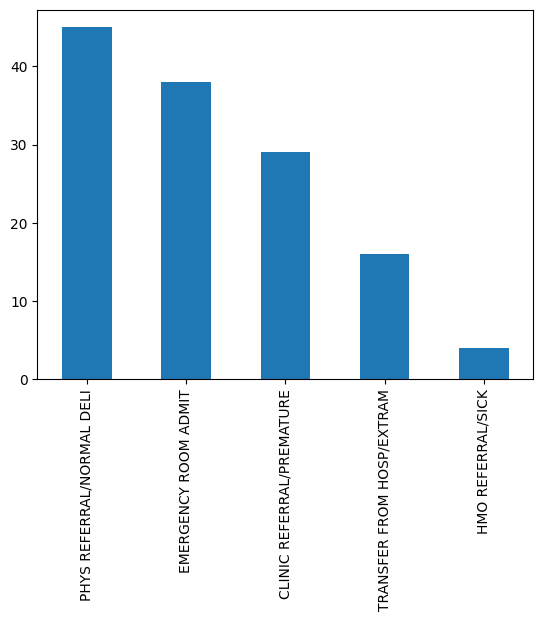

In [50]:
sample['admission_location'].value_counts().plot.bar()

In [51]:
train_data['admission_type'].value_counts()

EMERGENCY    92
NEWBORN      18
ELECTIVE     16
URGENT        6
Name: admission_type, dtype: int64

<Axes: >

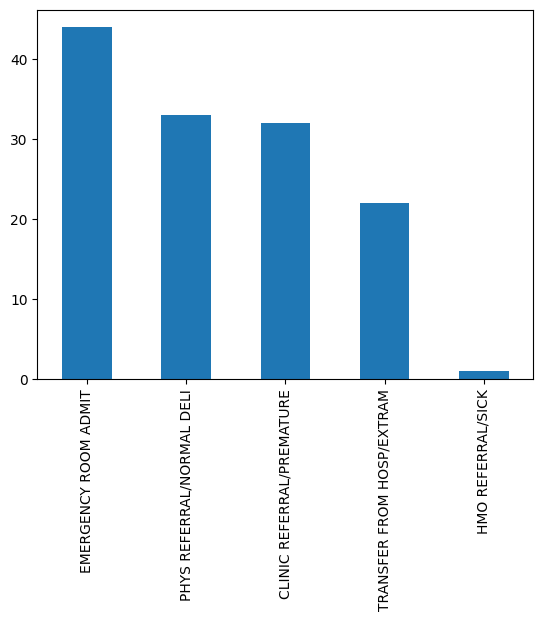

In [52]:
train_data['admission_location'].value_counts().plot.bar()

<Axes: xlabel='admission_type', ylabel='admission_location'>

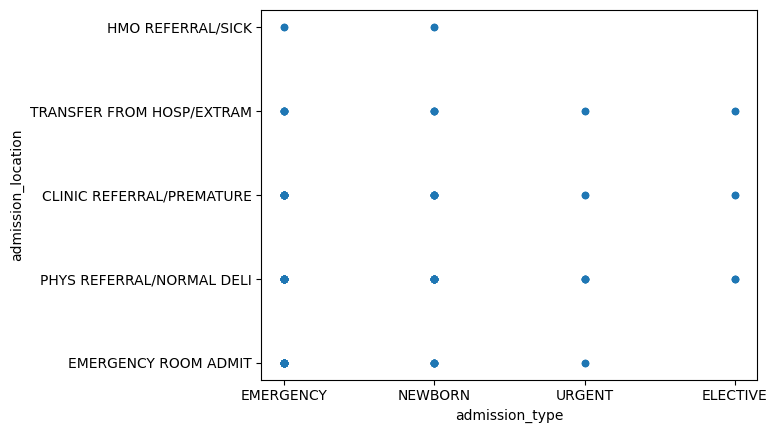

In [53]:
sample.plot.scatter(x='admission_type',y='admission_location')

<Axes: xlabel='admission_type', ylabel='admission_location'>

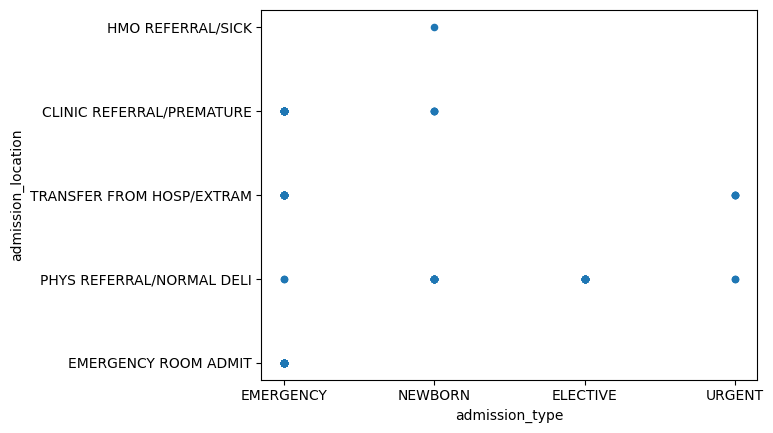

In [54]:
train_data.plot.scatter(x='admission_type',y='admission_location')

<Axes: >

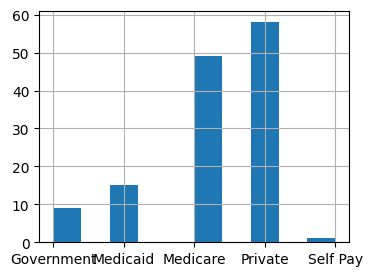

In [55]:
sample.sort_values(by='insurance')['insurance'].hist(figsize=(4,3))

<Axes: >

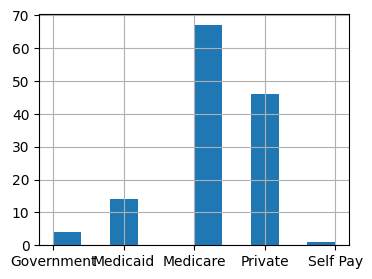

In [56]:
train_data.sort_values(by='insurance')['insurance'].hist(figsize=(4,3))

In [57]:
# sample.sort_values(by='admittime')['admittime'].hist()

In [58]:
# train_data.sort_values(by='admittime')['admittime'].hist()

In [59]:
sample['admittime'] = sample['admittime'].apply(lambda x: int(x/(60*60*24*365)))

<Axes: >

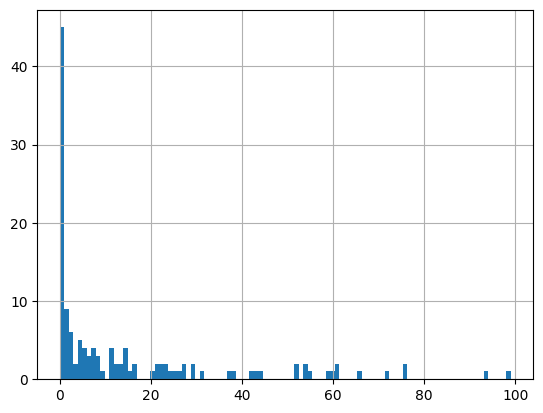

In [60]:
sample.sort_values(by='admittime')['admittime'].hist(bins=100)

In [61]:
# train_data.sort_values(by='admittime')['admittime'].apply(lambda x: int(x/(60*60*24*365))).hist(bins=100)

<Axes: >

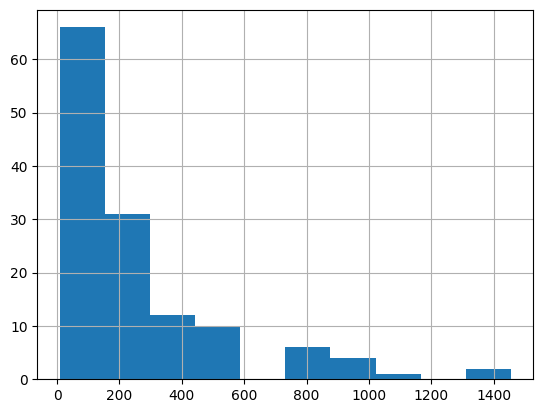

In [62]:
sample['dischtime'].apply(lambda x: int(x/(60*60))).hist()

<Axes: >

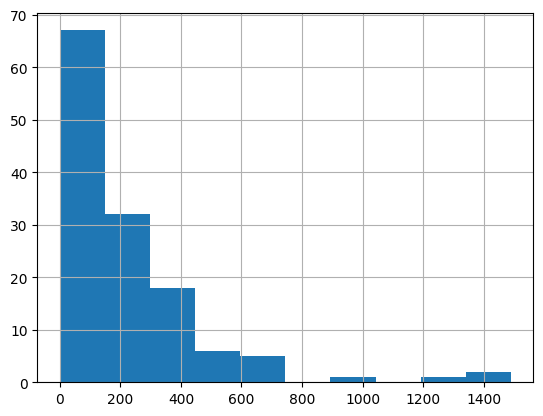

In [63]:
train_data['dischtime'].apply(lambda x: int(x/(60*60))).hist()